# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
# necessary imports
from maddpg import MADDPGAgent
from collections import deque
import torch

In [8]:
agent = MADDPGAgent(state_size=state_size, action_size=action_size, seed=0)

In [9]:
def train(n_episodes=10000, max_t=1000):
    
    scores = []                          # list to store the scores (averaged over all agents) estimated from each episode of training
    scores_window = deque(maxlen=100)    # last 100 averaged (over all agents) scores
    scores_mean = []                     # list to store the avg score (averaged over all agents) for 100 consecutive episodes
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # set initial value of score as 0
        scores_list = np.zeros(num_agents)     # list to store the scores of each agent for very episode
        
        # get initial state ===> dimension will be (num_agents,)
        states = env_info.vector_observations
        
        # resetting the noise process
        agent.reset()
        
        
        for t_step in range(max_t):
            
            # taking actions based upon current estimate of DDPG policy for all agents
            actions = agent.act(states)
            
            # now sending these actions to the envirnonment so that each agent can transition to the next state indepemdently
            env_info = env.step(actions)[brain_name]
           
            # get the next states ===> dimension will be (num_agents,)
            next_states = env_info.vector_observations
            
            # get the rewards
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # now the agents learns from these experience tuples
            agent.step(states, actions, rewards, next_states, dones)
            
            
            # current_state <==== next_state
            states = next_states
            
            # appending each agent immediate reward to it total undiscounted score
            scores_list += rewards
            
            # check if any of the agents have reach the end of episode
            if np.any(dones):
                break
                
        # episode ends here       
        
        # taking the max of scores of all agents for this episode
        score_for_this_episode = np.max(scores_list)
        
        # appending this score to scores_window
        scores_window.append(score_for_this_episode)    # save most recent score
        
        # calculate the avg score (over 100 consecutive episodes); this is our final score
        # this actually has to be more than 30.0
        
        final_score = np.mean(scores_window)                 # denotes the final score (=avg score over 100 consecutive episodes for all agents)
        
        # appeding the episode score to scores list
        scores.append(score_for_this_episode)                                 # save most recent score
    
        print ("\rEpisode {:}\t Average Score {:.2f}".format(i_episode, final_score), end="")
        
        if i_episode % 100 == 0:
            print ("\rEpsiode {:}\t Average Score {:.2f}".format(i_episode, final_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic1.pth')
            
        if i_episode >= 100:
            scores_mean.append(final_score)                                        # appending final score
            
        if final_score >= 0.5:    # environment solved
            print ("\nEnvironment solved in {:d} episodes!\tAverage Score: {:2f}".format(i_episode-100, final_score))
            
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor1.pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic1.pth")
            break
            
    return scores, scores_mean, agent

In [10]:
from workspace_utils import active_session

with active_session():
    dscores, dscores_mean, agent = train()

Epsiode 100	 Average Score 0.00
Epsiode 200	 Average Score 0.00
Epsiode 300	 Average Score 0.00
Epsiode 400	 Average Score 0.02
Epsiode 500	 Average Score 0.02
Epsiode 600	 Average Score 0.03
Epsiode 700	 Average Score 0.02
Epsiode 800	 Average Score 0.01
Epsiode 900	 Average Score 0.01
Epsiode 1000	 Average Score 0.00
Epsiode 1100	 Average Score 0.00
Epsiode 1200	 Average Score 0.02
Epsiode 1300	 Average Score 0.03
Epsiode 1400	 Average Score 0.00
Epsiode 1500	 Average Score 0.02
Epsiode 1600	 Average Score 0.12
Epsiode 1700	 Average Score 0.10
Epsiode 1800	 Average Score 0.13
Epsiode 1900	 Average Score 0.11
Epsiode 2000	 Average Score 0.10
Epsiode 2100	 Average Score 0.18
Episode 2147	 Average Score 0.50
Environment solved in 2047 episodes!	Average Score: 0.502500


In [11]:
import matplotlib.pyplot as plt

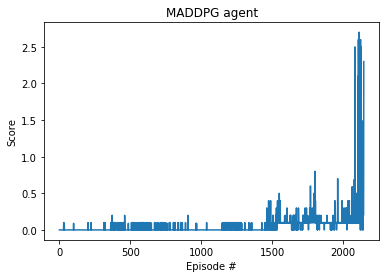

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(dscores)+1), dscores)
plt.title('MADDPG agent')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

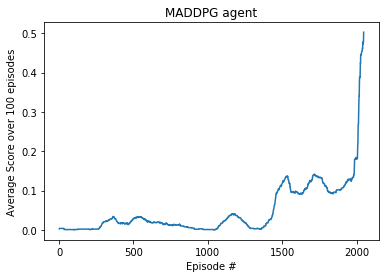

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(dscores_mean)+1), dscores_mean)
plt.title('MADDPG agent')
plt.ylabel('Average Score over 100 episodes')
plt.xlabel('Episode #')
plt.show()